Transformer
===========

This examples shows how to simulate a transformer.


In [ ]:


import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


from Transformer import Transformer



```
####################################################################################################

from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

####################################################################################################

class Transformer(SubCircuitFactory):

    __name__ = 'Transformer'
    __nodes__ = ('input_plus', 'input_minus',
                 'output_plus', 'output_minus')

    ##############################################

    def __init__(self,
                 turn_ratio,
                 primary_inductance=1@u_H,
                 copper_resistance=1@u_Ω,
                 leakage_inductance=1@u_mH,
                 winding_capacitance=20@u_pF,
                 coupling=.999,
             ):

        super().__init__()

        # For an ideal transformer you can reduce the values for the flux leakage inductances, the
        # copper resistors and the winding capacitances. But
        if copper_resistance <= 0:
            raise ValueError("copper resistance must be > 0")
        if leakage_inductance <= 0:
            raise ValueError("leakage inductance must be > 0")

        # primary_turns =
        # secondary_turns =
        # turn_ratio = primary_turns / secondary_turns
        # primary_inductance =
        # primary_inductance / secondary_inductance = turn_ratio**2
        secondary_inductance = primary_inductance / float(turn_ratio**2)

        # Primary
        self.C('primary', 'input_plus', 'input_minus', winding_capacitance)
        self.L('primary_leakage', 'input_plus', 1, leakage_inductance)
        primary_inductor = self.L('primary', 1, 2, primary_inductance)
        self.R('primary', 2, 'output_minus', copper_resistance)

        # Secondary
        self.C('secondary', 'output_plus', 'output_minus', winding_capacitance)
        self.L('secondary_leakage', 'output_plus', 3, leakage_inductance)
        secondary_inductor = self.L('secondary', 3, 4, secondary_inductance)
        self.R('secondary', 4, 'output_minus', copper_resistance)

        # Coupling
        self.CoupledInductor('coupling', primary_inductor.name, secondary_inductor.name, coupling)
```


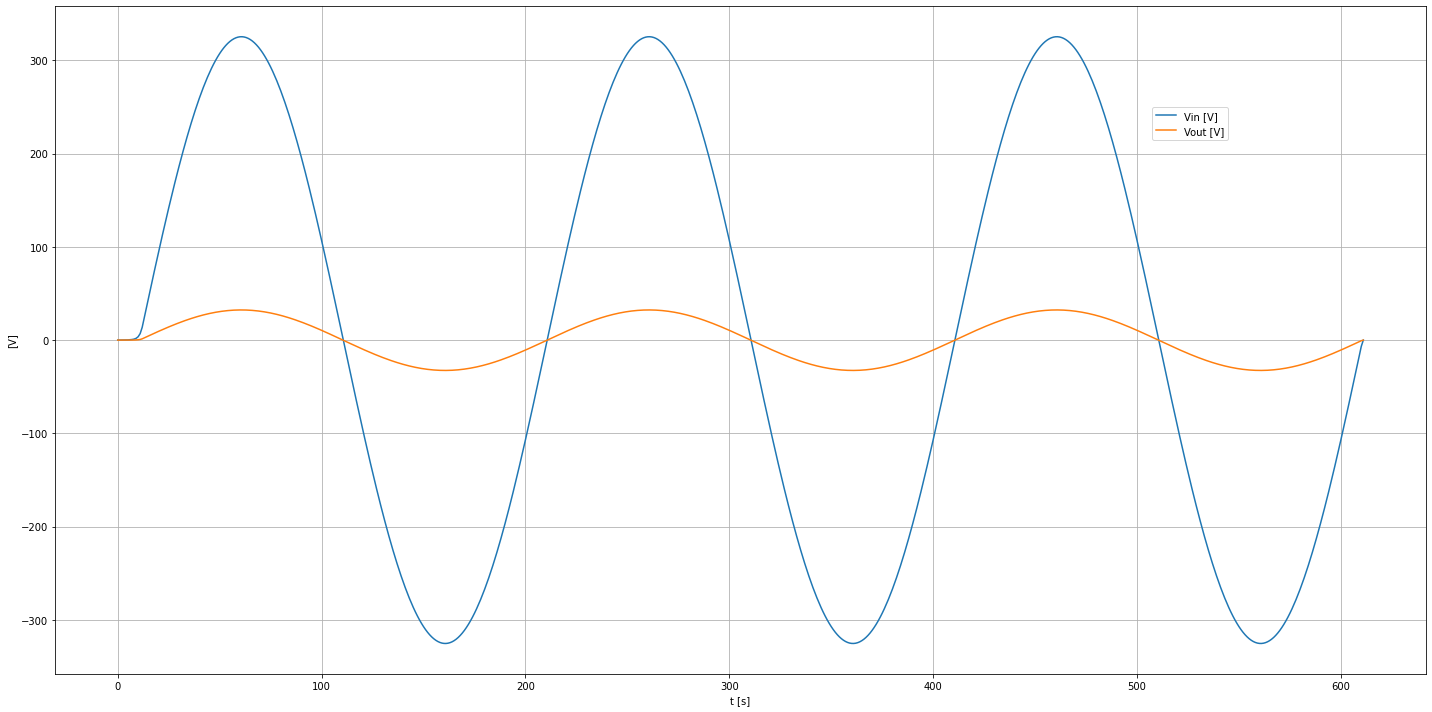

In [ ]:


circuit = Circuit('Transformer')

ac_line = circuit.AcLine('input', 'input', circuit.gnd, rms_voltage=230@u_V, frequency=50@u_Hz)
circuit.subcircuit(Transformer(turn_ratio=10))
circuit.X('transformer', 'Transformer', 'input', circuit.gnd, 'output', circuit.gnd)
circuit.R('load', 'output', circuit.gnd, 1@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=ac_line.period/200, end_time=ac_line.period*3)

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(analysis.input)
ax.plot(analysis.output)
ax.legend(('Vin [V]', 'Vout [V]'), loc=(.8,.8))
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('[V]')

plt.tight_layout()

